In [113]:
import os
import base64
import io
import json
from PIL import Image
from dotenv import load_dotenv
from openai import OpenAI
import torch
from diffusers import StableDiffusionPipeline
from rembg import remove
from ip_adapter import IPAdapter

# --------------- 환경 설정 및 모델 초기화 -----------------
load_dotenv()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [2]:
# ---------------유틸 함수 -----------------
def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def remove_background(image_path):
    with open(image_path, 'rb') as f:
        input_data = f.read()
    output_data = remove(input_data)
    return Image.open(io.BytesIO(output_data))

In [115]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    force_download=True  # 중요!
).to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [116]:
ip_adapter = IPAdapter(
    pipe,
    image_encoder_path="laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    ip_ckpt="ip-adapter_sd15.bin",
    device=device
)


In [117]:
product_image_path = "food1.jfif"
reference_image_path = 'image.png'

In [118]:
prompt = (
    "You are advertisement banner creater. "
    "Use given image as target image and create a advertisement poster. "
    "Put the target image bottom-left with suitable dish and make a room for ad banner on top"
)

In [119]:
negative_prompt = (
    "blurry, text artifacts, low resolution, extra fingers, distorted layout, watermark, "
    "bad anatomy, overexposed, logo error, low contrast"
)

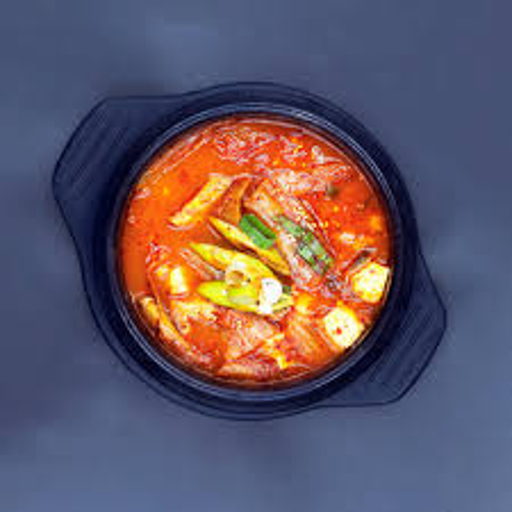

In [120]:
input_image = Image.open(product_image_path).convert("RGB").resize((512, 512))
input_image

In [121]:
image = ip_adapter.generate(
    pil_image=input_image,
    prompt=prompt,
    negative_prompt=negative_prompt,
    scale=0.8,
    num_inference_steps=40,
    guidance_scale=8
)

100%|██████████| 40/40 [00:09<00:00,  4.41it/s]


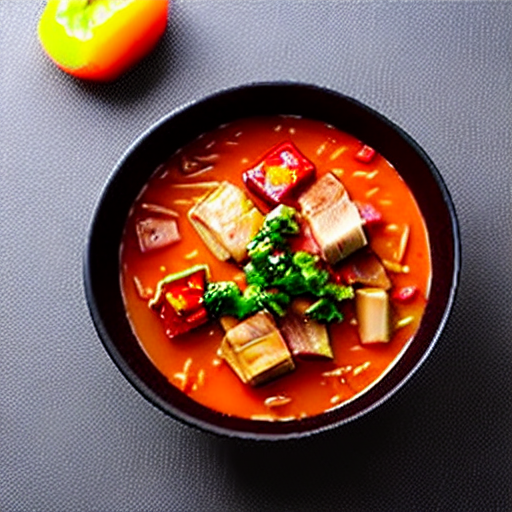

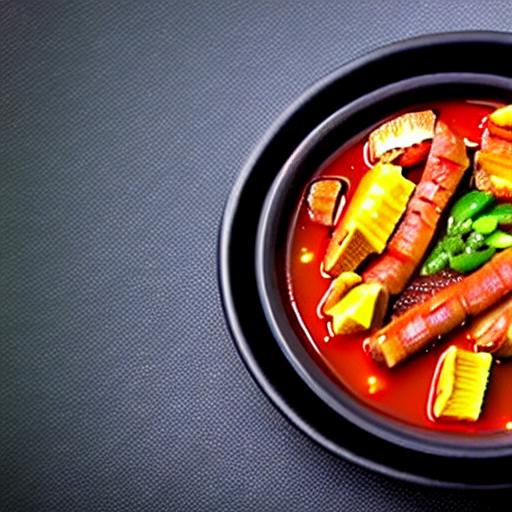

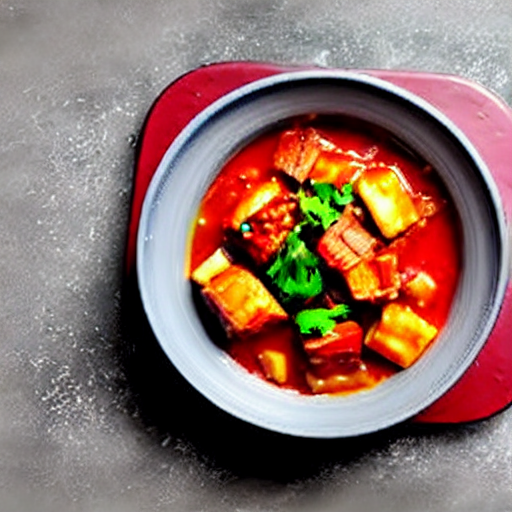

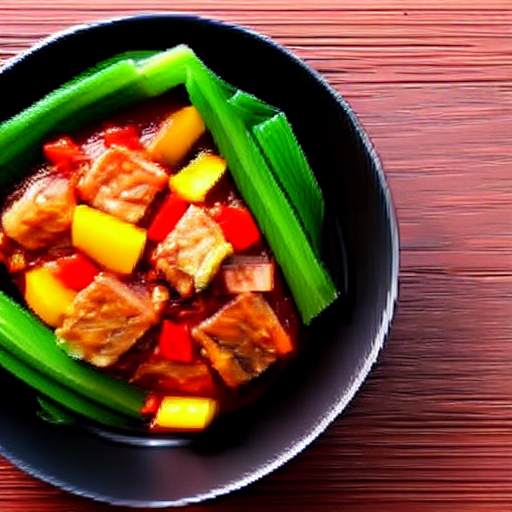

In [122]:
for img in image:
    display(img)

In [123]:
sys_prompt = (
    "You are an AI advertisement planner.\n"
    "Given a **main product image** and an **optional reference *ad* image**, write a short ad proposal in Korean.\n"
    "The second image is only for *stylistic reference*, not a second product.\n"
    "Explain what kind of background, mood, or layout would fit this product for a local Korean banner ad.\n"
    "Include tone (e.g., warm, luxurious), layout (e.g., product in center), and suggested copy.\n"
)

In [124]:
product_type = "Korean Food"
marketing_context = "홍보용 광고 배너 제작"

product_base64 = encode_image(product_image_path)
reference_base64 = encode_image(reference_image_path) if reference_image_path else None

In [154]:
user_prompt = [
    {"type": "text", "text": (
        f"Product type: {product_type}. Context: {marketing_context}.\n"
        "The second image, if present, is a visual reference for ad style, not another product."
    )},
    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{product_base64}"}}
] + (
    [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{reference_base64}"}}]
    if reference_base64 else []
)

In [155]:
message = [
    {
        "role": "system",
        "content": sys_prompt
    },
    {
        "role": "user",
        "content": user_prompt
    }
]

In [ ]:
response = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=message,
    max_tokens=300
)

In [ ]:
ad_desc = response.choices[0].message.content.strip()
ad_desc

In [129]:
ad_prompt = (
    "You're an assistant that converts ad ideas into short Stable Diffusion prompts.\n"
    "Summarize the style, mood, and layout from the Korean ad suggestion below.\n"
    "Output a 1-sentence English prompt within 77 CLIP tokens, suitable for clean commercial backgrounds.\n"
    "Exclude any product names, text, or brand mentions."
)

In [130]:
ad_message = [
    {
        "role": "system",
        "content": ad_prompt
    },
    {
        "role": "user",
        "content": ad_desc
    }
]

In [131]:
back_response = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=ad_message,
    max_tokens=77
)

In [144]:
sd_prompt = back_response.choices[0].message.content
sd_prompt

'A warm and inviting traditional Korean stew bowl steaming vibrantly on a dark, muted background with softly blurred Korean side dishes like seaweed and rice, evoking a cozy homemade meal atmosphere.empty the main plate'

In [151]:
ad_gen_img = pipe(prompt=f"advertise image {sd_prompt} fill blank the main plate")

100%|██████████| 50/50 [00:03<00:00, 15.37it/s]


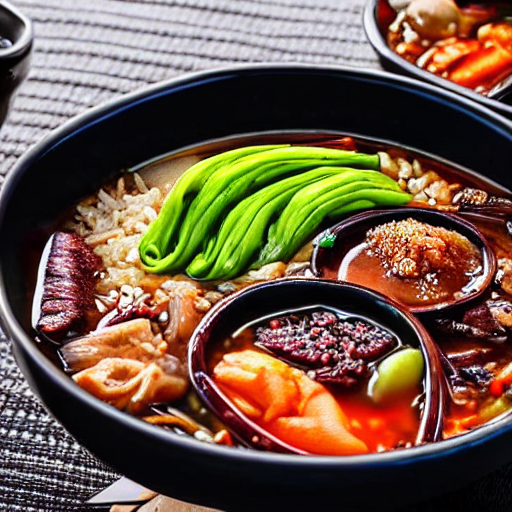

In [152]:
ad_gen_img.images[0]